# 3D Sensing and Sensor Fusion
### First Assignment - Kelemen Réka (E6T1DT)
***

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numba import prange, jit
from timeit import default_timer as timer

from stereo import stereo_estimation

# Parameters

In [2]:
focal_length = 3740
baseline = 160
window_size = 3
weight = 1000
scale = 2
dmin = 200
cost_type = "ssd"

# Load image

In [3]:
working_dir = os.getcwd()
print(working_dir)

C:\Users\rekak\Downloads\stereo_matching_e6t1dt


In [4]:
first = cv2.imread(working_dir + "/images/" + "art1.png", cv2.IMREAD_GRAYSCALE)
second = cv2.imread(working_dir + "/images/" + "art5.png", cv2.IMREAD_GRAYSCALE)
true = cv2.imread(working_dir + "/images/" + "art1_true.png", cv2.IMREAD_GRAYSCALE)

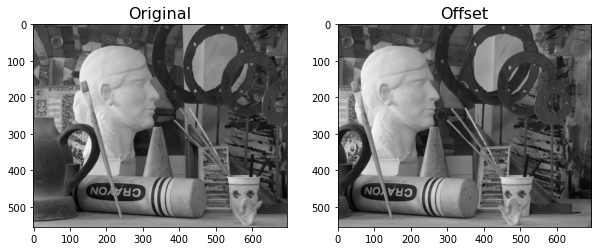

In [5]:
plt.figure(figsize=(10, 6))
images = [first, second]
titles = ["Original", "Offset"]
for i in range(1, 3):
    plt.subplot(120 + i)
    plt.title(titles[i - 1], fontsize=16)
    plt.imshow(images[i - 1], cmap="gray")

# Naive and DP stereo estimation

In [6]:
def call_with_monitor(function, display_name, verbose=True, **kwargs):
    start_time = timer()
    output = function(**kwargs)
    end_time = timer()
    elapsed_time = end_time - start_time
    if verbose:
        print("Time in seconds to complete", display_name, ":", round(elapsed_time, 6))
    return output, round(elapsed_time, 6)

In [7]:
height, width = first.shape

In [8]:
params = dict(
    window_size=window_size,
    height=height,
    width=width,
    left_image=first,
    right_image=second,
    scale=scale,
)

In [9]:
output_naive = call_with_monitor(
    stereo_estimation.naive_stereo_estimation,
    "naive stereo estimation",
    **params,
    cost_type=cost_type
)
output_dp = call_with_monitor(
    stereo_estimation.dynamic_programming_stereo_estimation,
    "DP stereo estimation",
    **params,
    weight=weight,
    cost_type=cost_type
)

Time in seconds to complete naive stereo estimation : 14.267553
Time in seconds to complete DP stereo estimation : 21.075879


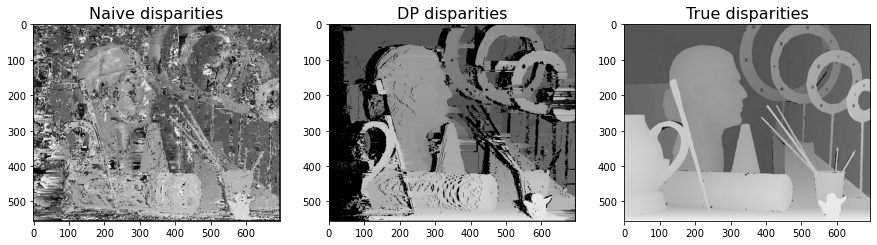

In [10]:
plt.figure(figsize=(15, 6))
titles = ["Naive disparities", "DP disparities", "True disparities"]
images = [output_naive[0], output_dp[0], true]
for i in range(1, 4):
    plt.subplot(130 + i)
    plt.title(titles[i - 1], fontsize=16)
    plt.imshow(images[i - 1], cmap="gray")

In [11]:
path = working_dir + "/output/point_clouds/"
stereo_estimation.write_to_point_cloud(
    width, height, output_dp[0], focal_length, baseline, dmin, scale, "art_dp", path
)

# Comparison

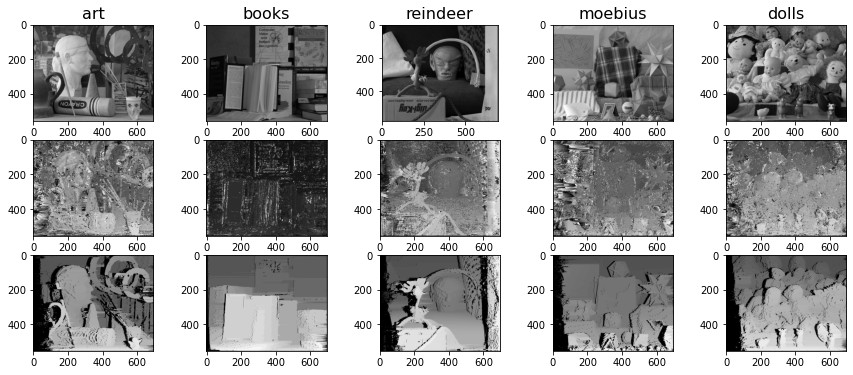

In [12]:
plt.figure(figsize=(15, 6))
dmin_dict = {"art": 200, "books": 200, "reindeer": 230, "moebius": 200, "dolls": 200}
file_names = list(dmin_dict.keys())
length = len(file_names)
times = []
for i in range(length):
    first = cv2.imread(working_dir + "/images/" + file_names[i] +"1.png", cv2.IMREAD_GRAYSCALE)
    second = cv2.imread(working_dir + "/images/" + file_names[i] +"5.png", cv2.IMREAD_GRAYSCALE)
    true = cv2.imread(working_dir + "/images/" + file_names[i] +"1_true.png", cv2.IMREAD_GRAYSCALE)
    
    plt.subplot(3, length, i + 1)
    plt.title(file_names[i], fontsize=16)
    plt.imshow(first, cmap="gray")
    
    output_naive = call_with_monitor(
    stereo_estimation.naive_stereo_estimation,
    "naive stereo estimation",
    verbose=False,
    window_size=window_size,
    height=height,
    width=width,
    left_image=first,
    right_image=second,
    scale=scale,
    cost_type=cost_type)
    
    output_dp = call_with_monitor(
    stereo_estimation.dynamic_programming_stereo_estimation,
    "DP stereo estimation",
    verbose=False,
    window_size=window_size,
    height=height,
    width=width,
    left_image=first,
    right_image=second,
    scale=scale,
    weight=weight,
    cost_type=cost_type)
    
    times.append([file_names[i], output_naive[1], output_dp[1]])
    
    plt.subplot(3, length, i + 1 + length)
    plt.imshow(output_naive[0], cmap="gray")
    
    plt.subplot(3, length, i + 1 + (length * 2))
    plt.imshow(output_dp[0], cmap="gray")
    
    stereo_estimation.write_to_point_cloud(
    width, height, output_dp[0], focal_length, baseline, dmin, dmin_dict[file_names[i]], file_names[i] + "_dp", path)

In [13]:
print("dataset \t naive (s) \t dp (s)".expandtabs(tabsize=15))
for i in times:
    s = str(i[0]) + "\t" + str(i[1]) + "\t " + str(i[2])
    print(s.expandtabs(tabsize=15))
print("The code is faster after it has been called once, as it no longer includes compilation time.")

dataset         naive (s)      dp (s)
art            1.67107         2.170827
books          1.721723        2.174878
reindeer       2.297363        2.655372
moebius        2.091947        2.615637
dolls          2.132649        2.724257
The code is faster after it has been called once, as it no longer includes compilation time.


# Effect of variables

In [14]:
def calculate_variable_effect(
    function_name=stereo_estimation.dynamic_programming_stereo_estimation,
    window_size=window_size, height=height, width=width, left_image=first, right_image=second, 
    scale=scale, weight=weight, cost_type=cost_type
):
    output_dp = call_with_monitor(
        function_name,
        display_name=None,
        verbose=False,
        window_size=window_size,
        height=height,
        width=width,
        left_image=first,
        right_image=second,
        scale=scale,
        weight=weight,
        cost_type=cost_type,
    )
    return output_dp

In [15]:
def plot_variable_effect(variable_name, list_of_values, length):
    plt.figure(figsize=(16, 5))
    params = {}
    for i in range(length):
        params[variable_name] = list_of_values[i]
        output_dp = calculate_variable_effect(**params)
        plt.subplot(1, length, i + 1)
        plt.title(str(variable_name) + " = " + str(list_of_values[i]) + "\n" + str(output_dp[1]) + " s", fontsize=16)
        plt.imshow(output_dp[0], cmap="gray")
    plt.show()

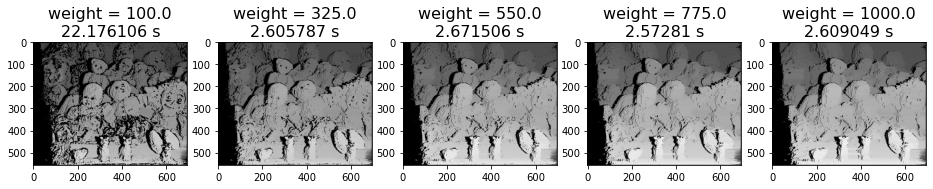

In [16]:
occlusions = np.linspace(100, 1000, 5)
plot_variable_effect("weight", occlusions, len(occlusions))

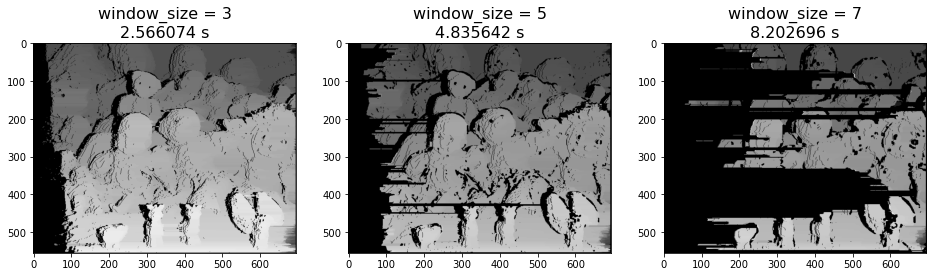

In [17]:
windows = [3, 5, 7]
plot_variable_effect("window_size", windows, len(windows))

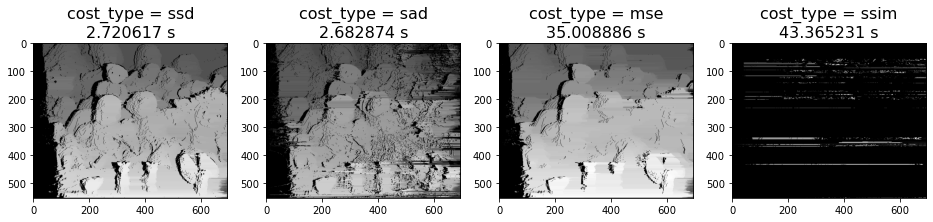

In [18]:
cost_types = ["ssd", "sad", "mse", "ssim"]
plot_variable_effect("cost_type", cost_types, len(cost_types))
# SSIM works well with weight=0